In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
import tensorflow as tf
from tensorflow.python.keras.layers import  Input,  Dense, LSTM, Concatenate, Dropout, Bidirectional
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

from tensorflow.keras import datasets, layers, models
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [3]:
wind_columns = [ 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']
wind_angle_columns = ['guitrancourt_Direction (deg N)','lieusaint_Direction (deg N)','lvs-pussay_Direction (deg N)',
 'parc-du-gatinais_Direction (deg N)','arville_Direction (deg N)','boissy-la-riviere_Direction (deg N)','angerville-1_Direction (deg N)', 
 'angerville-2_Direction (deg N)','guitrancourt-b_Direction (deg N)','lieusaint-b_Direction (deg N)','lvs-pussay-b_Direction (deg N)',
 'parc-du-gatinais-b_Direction (deg N)','arville-b_Direction (deg N)','boissy-la-riviere-b_Direction (deg N)','angerville-1-b_Direction (deg N)','angerville-2-b_Direction (deg N)'

]
wind_speed_columns = set(wind_columns) - set(wind_angle_columns)
wind_speed_columns = list(wind_speed_columns)

In [4]:
df = pd.read_csv("combined_energy_data.csv")

In [5]:
## convert it to datetime
df['datetime'] = pd.to_datetime(df.datetime)
agg_columns =  ["datetime","Wind"]
required_columns = ["Hours"] + agg_columns + [i for i in df.columns[12:]]
df_agg = df[agg_columns].groupby([df.datetime.dt.floor("H")]).agg(["mean","median","max","min","std","sum"])
df_agg.columns = df_agg.columns.map('_'.join)
df_agg = df_agg.reset_index()


In [6]:
df_merged = df_agg.merge(df[required_columns], how="left", on="datetime")

In [7]:
train_index = 8758
test_index = 17517
holdout_index = 26276

In [8]:
df_interpolated = df_merged.interpolate(method="linear")
df_interpolated = df_interpolated[2:]
df_interpolated = df_interpolated.reset_index(drop=True)
df_interpolated.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Wind_sum,Hours,Wind,guitrancourt_Speed(m/s),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,02:00,0.0,1.961667,...,2.505,221.333333,2.516667,221.333333,2.723333,221.833333,2.72,223.5,2.72,223.5
1,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,03:00,0.0,2.063333,...,2.500,217.666667,2.513333,217.666667,2.716667,217.666667,2.70,219.0,2.70,219.0
2,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,04:00,0.0,2.165000,...,2.495,214.000000,2.510000,214.000000,2.710000,213.500000,2.68,214.5,2.68,214.5
3,2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,05:00,0.0,2.266667,...,2.490,210.333333,2.506667,210.333333,2.703333,209.333333,2.66,210.0,2.66,210.0
4,2017-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,06:00,0.0,2.368333,...,2.485,206.666667,2.503333,206.666667,2.696667,205.166667,2.64,205.5,2.64,205.5


In [9]:
wind_sum_T_plus_18 = df_interpolated.Wind_sum

In [10]:
def get_loss_len(df):
    return df.shape[0] - df.dropna().shape[0]

In [11]:
def get_lag(series,number_of_frame,lead_time=18,title_name="Wind_mean_T_plus_"):
    df = pd.DataFrame()
    for i in range(lead_time,number_of_frame+lead_time):
        df[title_name+ str(-i)] = series.shift(-i-lead_time)
    return df
    

In [12]:
# get wind sum frame data

In [13]:
wind_sum_from_0_frame_5 = get_lag(wind_sum_T_plus_18,5) # T0
wind_sum_lag_29_frame_3 = get_lag(wind_sum_T_plus_18,3,29) #T-29 lag_month
wind_sum_lag_379_frame_3 = get_lag(wind_sum_T_plus_18,3,379) #T-379 lag month
wind_sum_target = get_lag(wind_sum_T_plus_18,1,0)

In [14]:
# get wind speed frame data
wind_speed_columns

['guitrancourt_Speed(m/s)',
 'lvs-pussay_Speed(m/s)',
 'parc-du-gatinais_Speed(m/s)',
 'guitrancourt-b_Speed(m/s)',
 'lieusaint-b_Speed(m/s)',
 'lvs-pussay-b_Speed(m/s)',
 'arville_Speed(m/s)',
 'boissy-la-riviere_Speed(m/s)',
 'angerville-1-b_Speed(m/s)',
 'angerville-2_Speed(m/s)',
 'angerville-1_Speed(m/s)',
 'boissy-la-riviere-b_Speed(m/s)',
 'lieusaint_Speed(m/s)',
 'angerville-2-b_Speed(m/s)',
 'parc-du-gatinais-b_Speed(m/s)',
 'arville-b_Speed(m/s)']

In [15]:
df_wind_speed = df_interpolated[wind_speed_columns]

In [16]:
wind_speed_group_1 = ["guitrancourt_Speed(m/s)","guitrancourt-b_Speed(m/s)","lvs-pussay-b_Speed(m/s)"]#0,1,2
wind_speed_group_2 = list(set(wind_speed_columns) - set(wind_speed_group_1))

In [17]:
df_wind_speed_group_1 = []
for i in wind_speed_group_1:
    df_wind_speed_group_1.append(get_lag(df_wind_speed[i],3,0,i+"_T_plus_"))
    
df_wind_speed_group_1 = pd.concat(df_wind_speed_group_1,axis=1)
    

In [18]:
df_wind_speed_group_2 = []
for i in wind_speed_group_2:
    df_wind_speed_group_2.append(get_lag(df_wind_speed[i],3,-1,i+"_T_plus_"))
df_wind_speed_group_2 = pd.concat(df_wind_speed_group_2,axis=1)

In [19]:
#make new persistance

In [20]:
persistance = np.array(get_lag(wind_sum_T_plus_18,1,18))+np.array(get_lag(wind_sum_T_plus_18,1,19))+np.array(get_lag(wind_sum_T_plus_18,1,30))
persistance /= 3 

# Test train split

In [21]:
lost = get_loss_len(wind_sum_lag_379_frame_3)

In [22]:
lost

760

In [23]:
df_wind_speed_group_2.head() # 2na as i shifted 1

,lvs-pussay_Speed(m/s)_T_plus_1,lvs-pussay_Speed(m/s)_T_plus_0,lvs-pussay_Speed(m/s)_T_plus_-1,lieusaint-b_Speed(m/s)_T_plus_1,lieusaint-b_Speed(m/s)_T_plus_0,lieusaint-b_Speed(m/s)_T_plus_-1,boissy-la-riviere_Speed(m/s)_T_plus_1,boissy-la-riviere_Speed(m/s)_T_plus_0,boissy-la-riviere_Speed(m/s)_T_plus_-1,angerville-1-b_Speed(m/s)_T_plus_1,...,arville_Speed(m/s)_T_plus_-1,angerville-2_Speed(m/s)_T_plus_1,angerville-2_Speed(m/s)_T_plus_0,angerville-2_Speed(m/s)_T_plus_-1,boissy-la-riviere-b_Speed(m/s)_T_plus_1,boissy-la-riviere-b_Speed(m/s)_T_plus_0,boissy-la-riviere-b_Speed(m/s)_T_plus_-1,arville-b_Speed(m/s)_T_plus_1,arville-b_Speed(m/s)_T_plus_0,arville-b_Speed(m/s)_T_plus_-1
0,NaN,NaN,1.82,NaN,NaN,2.766667,NaN,NaN,1.773333,NaN,...,1.558333,NaN,NaN,1.78,NaN,NaN,2.723333,NaN,NaN,2.516667
1,NaN,1.82,1.93,NaN,2.766667,2.773333,NaN,1.773333,1.886667,NaN,...,1.666667,NaN,1.78,1.89,NaN,2.723333,2.716667,NaN,2.516667,2.513333
2,1.82,1.93,2.04,2.766667,2.773333,2.780000,1.773333,1.886667,2.000000,2.72,...,1.775000,1.78,1.89,2.00,2.723333,2.716667,2.710000,2.516667,2.513333,2.510000
3,1.93,2.04,2.15,2.773333,2.780000,2.786667,1.886667,2.000000,2.113333,2.70,...,1.883333,1.89,2.00,2.11,2.716667,2.710000,2.703333,2.513333,2.510000,2.506667
4,2.04,2.15,2.26,2.780000,2.786667,2.793333,2.000000,2.113333,2.226667,2.68,...,1.991667,2.00,2.11,2.22,2.710000,2.703333,2.696667,2.510000,2.506667,2.503333


In [24]:
wind_sum_from_0_frame_5_dropna = wind_sum_from_0_frame_5[2:-lost].reset_index(drop=True)
wind_sum_lag_29_frame_3_dropna  = wind_sum_lag_29_frame_3[2:-lost].reset_index(drop=True)
wind_sum_lag_379_frame_3_dropna  = wind_sum_lag_379_frame_3[2:-lost].reset_index(drop=True)
wind_speed_group_1_dropna  = df_wind_speed_group_1[2:-lost].reset_index(drop=True)
wind_speed_group_2_dropna  = df_wind_speed_group_2[2:-lost].reset_index(drop=True)
wind_sum_target_dropna = wind_sum_target[2:-lost]
persistance_dropna = persistance[2:-lost]

In [25]:
wind_speed_group_2

['lvs-pussay_Speed(m/s)',
 'lieusaint-b_Speed(m/s)',
 'boissy-la-riviere_Speed(m/s)',
 'angerville-1-b_Speed(m/s)',
 'angerville-1_Speed(m/s)',
 'lieusaint_Speed(m/s)',
 'angerville-2-b_Speed(m/s)',
 'parc-du-gatinais-b_Speed(m/s)',
 'parc-du-gatinais_Speed(m/s)',
 'arville_Speed(m/s)',
 'angerville-2_Speed(m/s)',
 'boissy-la-riviere-b_Speed(m/s)',
 'arville-b_Speed(m/s)']

In [26]:
train_wind_sum_from_0_frame_5 = wind_sum_from_0_frame_5_dropna[:train_index]
test_wind_sum_from_0_frame_5 = wind_sum_from_0_frame_5_dropna[train_index:test_index]
holdout_wind_sum_from_0_frame_5 = wind_sum_from_0_frame_5_dropna[test_index:holdout_index]

train_wind_sum_lag_29_frame_3 = wind_sum_lag_29_frame_3_dropna[:train_index]
test_wind_sum_lag_29_frame_3 = wind_sum_lag_29_frame_3_dropna[train_index:test_index]
holdout_wind_sum_lag_29_frame_3 = wind_sum_lag_29_frame_3_dropna[test_index:holdout_index]

train_wind_sum_lag_379_frame_3 = wind_sum_lag_379_frame_3_dropna[:train_index]
test_wind_sum_lag_379_frame_3 = wind_sum_lag_379_frame_3_dropna[train_index:test_index]
holdout_wind_sum_lag_379_frame_3 = wind_sum_lag_379_frame_3_dropna[test_index:holdout_index]

train_wind_speed_group_1 = wind_speed_group_1_dropna[:train_index]
test_wind_speed_group_1  = wind_speed_group_1_dropna[train_index:test_index]
holdout_wind_speed_group_1  = wind_speed_group_1_dropna[test_index:holdout_index]

train_wind_speed_group_2 = wind_speed_group_2_dropna[:train_index]
test_wind_speed_group_2  = wind_speed_group_2_dropna[train_index:test_index]
holdout_wind_speed_group_2  = wind_speed_group_2_dropna[test_index:holdout_index]

y = wind_sum_target
train_y = y[:train_index]
test_y = y[train_index:test_index]
holdout_y = y[train_index:test_index]

train_persistance = persistance[:train_index]
test_persistance = persistance[train_index:test_index]
holdout_persistance = persistance[test_index:holdout_index]


In [27]:
wind_sum_from_0_frame_5_sc = MinMaxScaler()
wind_sum_lag_29_frame_3_sc  = MinMaxScaler()
wind_sum_lag_379_frame_3_sc  = MinMaxScaler()
wind_speed_group_1_sc       = MinMaxScaler()
wind_speed_group_2_sc        = MinMaxScaler()
y_scaler_sc                = MinMaxScaler()
p_scaler_sc                = MinMaxScaler()

In [28]:
train_wind_sum_from_0_frame_5_norm = wind_sum_from_0_frame_5_sc.fit_transform(train_wind_sum_from_0_frame_5)
train_wind_sum_lag_29_frame_3_norm = wind_sum_lag_29_frame_3_sc.fit_transform(train_wind_sum_lag_29_frame_3)
train_wind_sum_lag_379_frame_3_norm = wind_sum_lag_379_frame_3_sc.fit_transform(train_wind_sum_lag_379_frame_3)
train_wind_speed_group_1_norm = wind_speed_group_1_sc.fit_transform(train_wind_speed_group_1)       
train_wind_speed_group_2_norm = wind_speed_group_2_sc.fit_transform(train_wind_speed_group_2)      
train_y_norm  = y_scaler_sc.fit_transform(train_y)                
train_persistance_norm  = p_scaler_sc.fit_transform(train_persistance)                

In [29]:
test_wind_sum_from_0_frame_5_norm = wind_sum_from_0_frame_5_sc.transform(test_wind_sum_from_0_frame_5)
test_wind_sum_lag_29_frame_3_norm = wind_sum_lag_29_frame_3_sc.transform(test_wind_sum_lag_29_frame_3)
test_wind_sum_lag_379_frame_3_norm = wind_sum_lag_379_frame_3_sc.transform(test_wind_sum_lag_379_frame_3)
test_wind_speed_group_1_norm = wind_speed_group_1_sc.transform(test_wind_speed_group_1)       
test_wind_speed_group_2_norm = wind_speed_group_2_sc.transform(test_wind_speed_group_2)      
test_y_norm = y_scaler_sc.transform(test_y)                
test_persistance_norm = p_scaler_sc.transform(test_persistance)  

In [30]:
holdout_wind_sum_from_0_frame_5_norm = wind_sum_from_0_frame_5_sc.transform(holdout_wind_sum_from_0_frame_5)
holdout_wind_sum_lag_29_frame_3_norm = wind_sum_lag_29_frame_3_sc.transform(holdout_wind_sum_lag_29_frame_3)
holdout_wind_sum_lag_379_frame_3_norm = wind_sum_lag_379_frame_3_sc.transform(holdout_wind_sum_lag_379_frame_3)
holdout_wind_speed_group_1_norm = wind_speed_group_1_sc.transform(holdout_wind_speed_group_1)       
holdout_wind_speed_group_2_norm = wind_speed_group_2_sc.transform(holdout_wind_speed_group_2)      
holdout_y_norm = y_scaler_sc.transform(holdout_y)                
holdout_persistance_norm = p_scaler_sc.transform(holdout_persistance)  

In [31]:
# wind_sum_5 = StandardScaler()
# wind_sum_3 = StandardScaler()
# wind_sum_1 = StandardScaler()
# wind_speed_group1 = StandardScaler()
# wind_speed_group2 = StandardScaler()
# wind_sum__from_0_frame_5_norm = wind_sum_5.fit_transform(wind_sum__from_t_frame_5_dropna)

# wind_sum_lag_29_frame_3_norm = wind_sum_3.fit_transform(wind_sum_lag_29_frame_3_dropna)
# wind_sum_lag_379_frame_3_norm = wind_sum_3.transform(wind_sum_lag_29_frame_3_dropna)

# persistance_norm = wind_sum_1.fit_transform(persistance)

# wind_speed_group_1_norm = wind_speed_group1.fit_transform(wind_speed_group_1_dropna)
# wind_speed_group_2_norm = wind_speed_group2.fit_transform(wind_speed_group_2_dropna)

# y = wind_sum_1.transform(wind_sum_target)[2:-lost]

In [130]:
all_things = [train_wind_sum_from_0_frame_5_norm,test_wind_sum_from_0_frame_5_norm,holdout_wind_sum_from_0_frame_5_norm,
 train_wind_sum_lag_29_frame_3_norm,test_wind_sum_lag_29_frame_3_norm,holdout_wind_sum_lag_29_frame_3_norm,
 train_wind_sum_lag_379_frame_3_norm,test_wind_sum_lag_379_frame_3_norm ,holdout_wind_sum_lag_379_frame_3_norm,
 train_wind_speed_group_1_norm,test_wind_speed_group_1_norm ,holdout_wind_speed_group_1_norm,
 train_wind_speed_group_2_norm,test_wind_speed_group_2_norm ,holdout_wind_speed_group_2_norm,
]
all_pad_size =[ i.reshape((*i.shape),1) for i in all_things]

train_feature_input = [all_pad_size[i] for i in range(0,len(all_pad_size),3)]

test_feature_input = [all_pad_size[i] for i in range(1,len(all_pad_size),3)]

holdout_feature_input = [all_pad_size[i] for i in range(2,len(all_pad_size),3)]


In [131]:
for i in range(len(holdout_feature_input)):
    print(holdout_feature_input[i].shape)

(8759, 5, 1)
(8759, 3, 1)
(8759, 3, 1)
(8759, 9, 1)
(8759, 39, 1)


In [34]:
def LSTM_feature_recognizer(name,shape,dropout,recurrent_dropout,lr):
    sequence_input = Input(shape=(shape[1],shape[2],), name=name)
    
    sequence_out = (LSTM(int(shape[2]), input_shape=(shape[1],shape[2]),dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6),return_sequences=True))(sequence_input)
    sequence_out = (LSTM(int(shape[2]/2+1), input_shape=(shape[1],shape[2]),dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6),return_sequences=True))(sequence_input)
    sequence_out = (LSTM(int(shape[2]/4+1), dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6)))(sequence_out)
    
    preds = Dense(5,activation="relu")(sequence_out)
    
    model = Model(inputs=sequence_input,outputs=preds)
    optimizer = Adam(lr)
    model.compile(loss="mean_squared_error",optimizer=optimizer)
    
    return model

In [35]:
def CNN_feature_recognizer(name,shape,dropout,recurrent_dropout,lr):
    
    sequence_input = Input(shape=(shape[1],shape[2],), name=name)
    sequence_out = (layers.Conv1D(32, 3, activation='relu', input_shape= (shape[1],shape[2])))(sequence_input)
    sequence_out = (layers.MaxPooling1D(2))(sequence_out)
    

    sequence_out = layers.Flatten()(sequence_out)
    
    preds = Dense(40,activation="relu")(sequence_out)
    preds = Dense(20,activation="relu")(preds)
    preds = Dense(5,activation="relu")(preds)
    
    model = Model(inputs=sequence_input,outputs=preds)
    optimizer = Adam(lr)
    model.compile(loss="mean_squared_error",optimizer=optimizer)
    
    return model

In [37]:
def backbone_network(models,shapes,persistant_shape,dropout,recurrent_dropout,lr):
    shapes = [i.shape for i in shapes]
    features_input_1 = Input(shape=(shapes[0][1],shapes[0][2],), name="features_input1")
    features_input_2 = Input(shape=(shapes[1][1],shapes[1][2],), name="features_input2")
    features_input_3 = Input(shape=(shapes[2][1],shapes[2][2],), name="features_input3")
    features_input_4 = Input(shape=(shapes[3][1],shapes[3][2],), name="features_input4")
    features_input_5 = Input(shape=(shapes[4][1],shapes[4][2],), name="features_input5")
    features_inputs = [features_input_1,features_input_2,features_input_3,features_input_4,features_input_5]
    persistant_input = Input(shape=(persistant_shape,),name="persistant_input")
    
    result = []
    for i in range(len(models)):
        result.append(models[i](features_inputs[i]))
    x1 = tf.concat(result,axis=1)
    x2 = Concatenate()([persistant_input,x1])
    x3 = Dense(40,activation="relu")(x2)
    x3 = Dense(30,activation="relu")(x2)
    x3 = Dense(20,activation="relu")(x2)
    x3 = Dense(5,activation="relu")(x3)
    preds = Dense(1,activation="relu")(x3)
    
    
    model = Model(inputs=[features_input_1,features_input_2,features_input_3,features_input_4,features_input_5,persistant_input],outputs=preds)
    optimizer = Adam(lr)
    model.compile(loss="mean_squared_error",optimizer=optimizer)
    
    return model

In [39]:
spatial_dropout = 0.1
dropout = 0.1
recurrent_dropout = 0.1
learning_rate = 3e-6

#create our first model
model_list = []
for i in range(0,len(train_feature_input)):
    model_list.append(LSTM_feature_recognizer("input",train_feature_input[i].shape,dropout, recurrent_dropout, learning_rate))
    #model_list.append(CNN_feature_recognizer("input",np.expand_dims(train_feature_input[i], axis=0),dropout, recurrent_dropout, learning_rate))

In [40]:
learning_rate_2 = 3e-6

In [41]:
model = backbone_network(model_list,train_feature_input,train_persistance_norm.shape[1],dropout,recurrent_dropout,learning_rate_2)

In [42]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features_input1 (InputLayer)    [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
features_input2 (InputLayer)    [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
features_input3 (InputLayer)    [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
features_input4 (InputLayer)    [(None, 9, 1)]       0                                            
____________________________________________________________________________________________

In [43]:
import gc
gc.collect()

0

In [44]:
for i in range(len(train_feature_input)):
    print(train_feature_input[i].min())
    print(train_feature_input[i].max())

0.0
0.9999999999999999
0.0
0.9999999999999999
0.0
0.9999999999999999
0.0
1.0
0.0
1.0000000000000002


In [45]:
checkpoint_filepath = "D:\AI4ImpactProject2"

In [46]:
model_checkpoint_callback_no_diff = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history1 = model.fit([*train_feature_input,train_persistance_norm], train_y_norm,epochs = 10, batch_size = 100, verbose = 1 ,callbacks=[model_checkpoint_callback_no_diff])

W0721 02:11:12.785299 16584 deprecation.py:323] From C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8758 samples
Epoch 1/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0567

W0721 02:11:58.116239 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 25s 3ms/sample - loss: 0.0568
Epoch 2/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0560

W0721 02:12:08.657260 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0561
Epoch 3/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0554

W0721 02:12:19.332260 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0554
Epoch 4/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0548

W0721 02:12:29.671806 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 10s 1ms/sample - loss: 0.0547
Epoch 5/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0543

W0721 02:12:40.262599 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0541
Epoch 6/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0534

W0721 02:12:51.465109 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0535
Epoch 7/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0528

W0721 02:13:02.032024 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0529
Epoch 8/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0522

W0721 02:13:13.385128 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0523
Epoch 9/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0518

W0721 02:13:24.522652 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 11s 1ms/sample - loss: 0.0517
Epoch 10/10
8700/8758 [============================>.] - ETA: 0s - loss: 0.0512

W0721 02:13:36.698611 16584 callbacks.py:986] Can save best model only with val_acc available, skipping.


8758/8758 [==============================] - 12s 1ms/sample - loss: 0.0512


In [47]:
test_y_hat = model.predict([*test_feature_input,test_persistance_norm])
test_y_hat_inversed = y_scaler_sc.inverse_transform(test_y_hat)

In [48]:
print("test diff Deep learning")
print(np.sqrt(mean_squared_error(test_y_hat_inversed,test_y)))
print(mean_absolute_error(test_y_hat_inversed,test_y))

test diff Deep learning
8048.022407517553
5362.968405160775


In [89]:
p = get_lag(wind_sum_T_plus_18,1,18)[2:-lost]
p_train = p[:train_index]
p_test = p[train_index:test_index]
p_holdout = p[test_index:holdout_index]
print("test persistance")
print(np.sqrt(mean_squared_error(p_test,test_y)))
print(mean_absolute_error(p_test,test_y))

test persistance
8181.661854825197
5930.357346729079


In [132]:
holdout_y_hat = model.predict([*holdout_feature_input,holdout_persistance_norm])
holdout_y_hat_inversed = y_scaler_sc.inverse_transform(holdout_y_hat)

In [133]:
print("holdout diff Deep learning")
print(np.sqrt(mean_squared_error(holdout_y_hat_inversed,holdout_y)))
print(mean_absolute_error(holdout_y_hat_inversed,holdout_y))

holdout diff Deep learning
7970.466515473579
5433.824006339433


In [134]:
print("holdout persistant")
print(np.sqrt(mean_squared_error(p_holdout,holdout_y)))
print(mean_absolute_error(p_holdout,holdout_y))

holdout persistant
12661.142508741843
9298.26464208243


In [57]:
def trading(forecast,actual):
#execute the trading from the result of forecast and actual energy production
#forecast: an 1D array of forecast values (Unit:kWh)
#actual: an 1D array of actual values (Unit:kWh)
  
    #initial budget
    budget=1e9
    #counters initialize: short falling and panalty counter
    SFcount=0;
    Pcount=0;
    cashFlow=[1e9]
    
    for f,a in zip(forecast,actual):
        if f <= a:
            budget += f*10
        elif f > a:#short falling
            #calculate cost of spot price energy
            budget += a*10
            spotP = 20*(f-a)
            SFcount+= 1
            if budget >= spotP:
                budget -= 20*(f-a)
            else:
                #receive penalty from the government
                if budget>0:
                    #buy from grid if budget not equal to 0
                    spotP-=budget
                    budget=0
                #fine =5* spotP
                budget -= 5*spotP
                Pcount+=1
        cashFlow.append(budget)
    timeStep= list(range(0, len(cashFlow)))
    #Reporting
    plt.plot(timeStep,cashFlow)
    plt.show()
    print ("resultant budget: ",budget)
    print ("net profit: ",budget-1e9)
    print ("number of short falling: ",SFcount )
    print ("number of panalty: ",Pcount )

In [85]:
p_holdout.head() #persistant lead_time - 18

,Wind_mean_T_plus_-18
17519,2750.0
17520,2750.0
17521,2750.0
17522,4000.0
17523,5000.0


In [84]:
holdout_y.head()#persistant lead_time

,Wind_mean_T_plus_0
8758,24250.0
8759,22250.0
8760,21500.0
8761,20000.0
8762,21750.0


In [108]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

plt.rcParams["figure.figsize"] = (20,10)

In [121]:
y_predict_test = np.array([i if i>0 else 0  for i in test_y_hat_inversed])

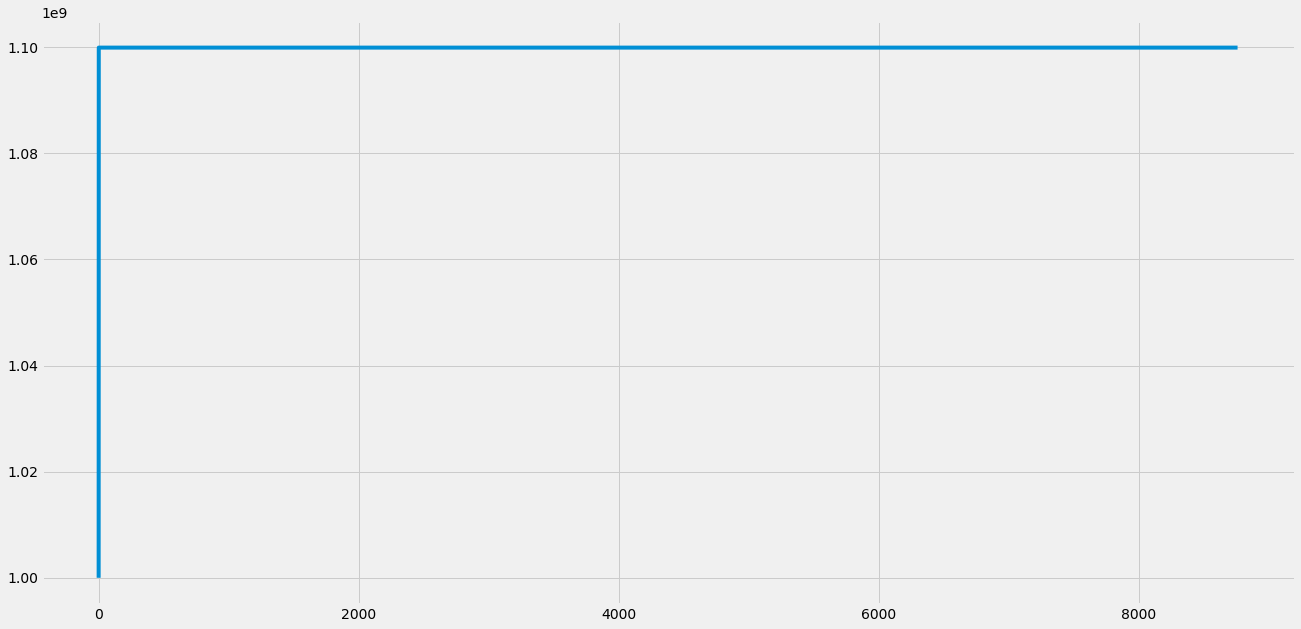

resultant budget:  [1.0999151e+09]
net profit:  [99915140.]
number of short falling:  2528
number of panalty:  0


In [122]:
trading(y_predict_test,np.array(test_y))

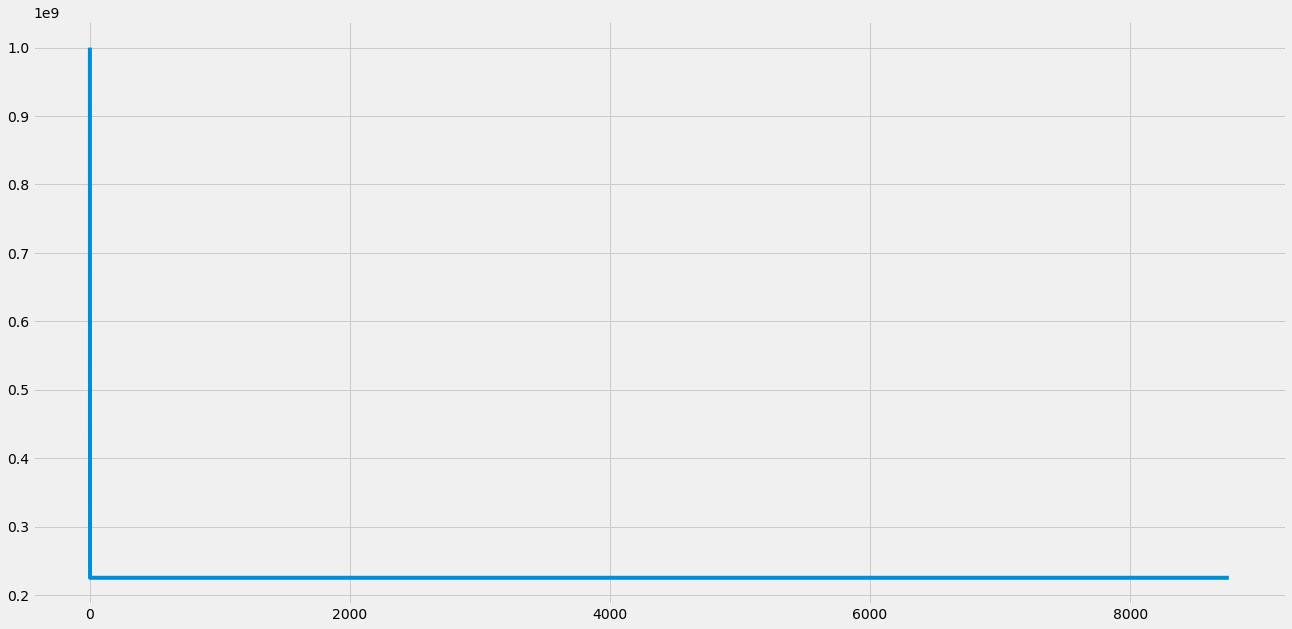

resultant budget:  [2.2523e+08]
net profit:  [-7.7477e+08]
number of short falling:  5201
number of panalty:  0


In [109]:
trading(np.array(p_holdout),np.array(holdout_y)) #persistant

In [110]:
y_predict_holdout = np.array([i if i>0 else 0  for i in holdout_y_hat_inversed])

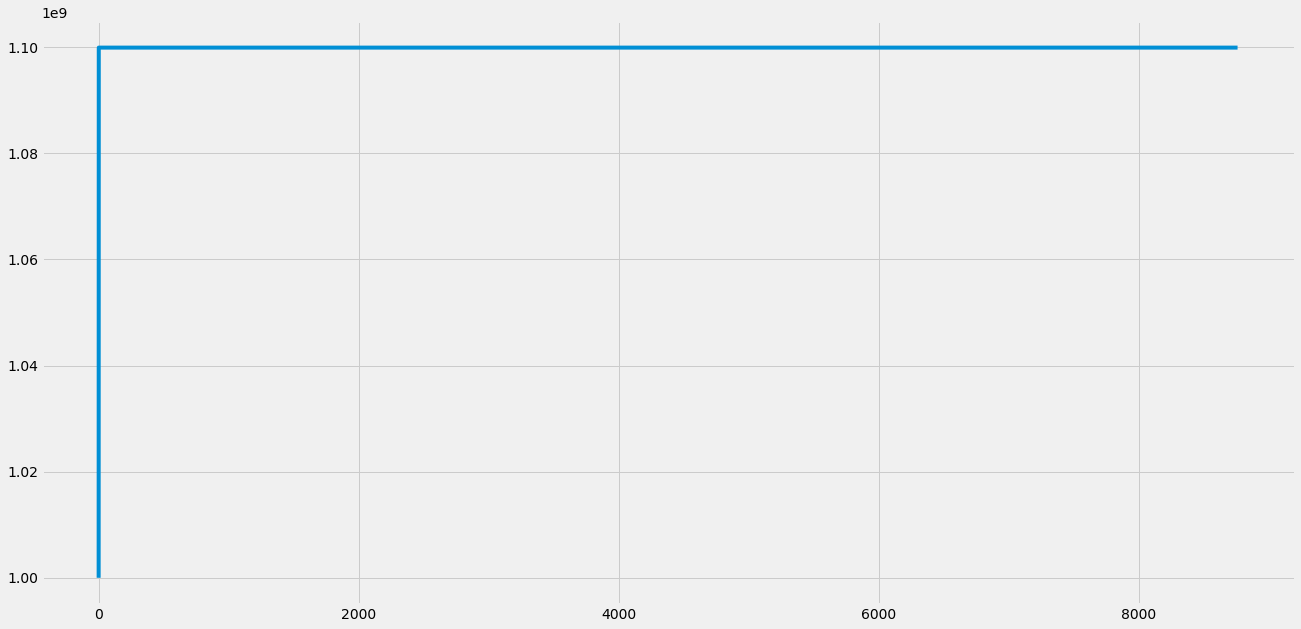

resultant budget:  [1.0999151e+09]
net profit:  [99915140.]
number of short falling:  2528
number of panalty:  0


In [113]:
trading(y_predict_holdout,np.array(holdout_y))

array([[5566.5894],
       [5974.698 ],
       [5948.025 ],
       ...,
       [1399.4849],
       [1252.9846],
       [1191.9196]], dtype=float32)

5362.968405160775